In [1]:
from IPython.display import HTML, display
css_file_path = "../../design/custom.css"
styles = "<link rel='stylesheet' href='%s'>" % css_file_path
display(HTML(styles))

# ANÁLISIS DEL EFECTO DE LA DIVERSIFICACIÓN EN EL RIESGO DE UNA CARTERA

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp
import plotly.graph_objects as go
from tqdm import tqdm

from utils import dibuja_covar

plt.style.use('ggplot')


<center>
    <img src="../imgs/tipos_de_riesgos.PNG"  alt="drawing" width="400">
</center>

## EFECTO DE LA DIVERSIFICACIÓN EN EL RIESGO DE UNA CARTERA

Vamos a analizar el efecto de la diversificación en el riesgo de una cartera. En este notebook, por simplicidad, empezaremos con carteras compuestas por activos con **retornos independientes**  $\Rightarrow \sigma_{i,j} = 0$.

1. Vamos a estudiar las fórmulas de la varianza de una cartera con $N$ activos

2. Vamos a calcular la varianza de una cartera con $N$ activos cuando $N \to \infty$

3. Vamos a generar retornos independientes de muchos activos usando uns distribución normal

4. Vamos a ir generando carteras cada vez con más activos y ver cómo afecta al riesgo de las carteras. Veremos dos tipos de carteras:

- Cartera equiponderada
- Cartera de mínima varianza

5. Posteriormente usaremos los prcios de cierre de los activos del S&P500 para ver cómo afecta la diversificación al riesgo de una cartera.



### Estudio de la varianza de una cartera con $n$ activos con retornos independientes

Hemos visto en el tema 1 la varianza de una cartera de dos activos:

$$\sigma^2(\tilde R_p)= \underset{\text{Activo 1}} {\underbrace{w_1^2\sigma^2(\tilde R_1)}}+\underset{\text{Activo 2}} {\underbrace{w_2^2\sigma^2(\tilde R_2)}}+ \underset{\text{Relación entre activos}} {\underbrace{2w_1w_2 \rho_{12} \sigma_1 \sigma_2}}$$
       


Podemos generalizar para una cartera con $n$ activos:

$$\sigma²(\tilde R_p)= \underset{\text{Riesgo Activos}} {\underbrace{\sum_{i=1}^n w_i² \sigma_i²}} + \underset{\text{Relación entre activos}} {\underbrace{\sum_{i=1}^n \sum_{j=1}^n w_i w_j \rho_{ij} \sigma_i \sigma_j}} $$




Si hacemos una cartera en la que invertimos la misma cantidad en cada activo $\Rightarrow w_i = \dfrac{1}{n}$, la varianza de la cartera se puede escribir como:

$$\sigma_p^2= \dfrac{1}{n^2}\sum_{i=1}^{n} \sigma _i^2 + \dfrac{1}{n^2}\sum_{i=1}^{n}\sum_{j=1}^{n}\sigma_{ij}$$

Además, si los **retornos son independientes**, $\sigma_{ij}=0$ y la varianza de la cartera se reduce a:

$$\sigma_p^2= \dfrac{1}{n^2}\sum_{i=1}^{n} \sigma _i²$$

Y cuando el número de activos tiende a infinito:

$$\lim_{n \to \infty} \sigma_p^2= \lim_{n \to \infty} \dfrac{1}{n^2}\sum_{i=1}^{n} \sigma _i^2 = 0$$

Por lo tanto, la diversificación, cuando los retornos son independientes, eliminan también el riesgo sistemático.

Veamos este resultado con datos reales:

1. Vamos a ir creando carteras cada vez con más activos y vamos a ver cómo afecta eso a las distintas medidas del riesgo.

2. En una segunda fase, vamos a ordenar los activos de mayor a menor volatilidad para volver a generar las carteras cada vez con más activos para ver como, agrupando de manera "inteligente" podemos mejorar el riesgo.

Para poder comparar, en todos los casos vamos a emplear, por un lado, la **cartera equiponderada** y, por otro lado, la de **menor volatilidad** que se pueda generar con los activos en la cartera. Las medidas que vamos a emplear son:

* **Volatilidad**
 
* **VaR** 

* **CVaR** 

Genero las medias y volatilidades de los activos usando una distribución normal. 


In [7]:
num_act = 500 # Número de activos, elegimos 500 activos para que sea similar al caso del sp500
num_dias = 1000 # Número de días a generar 
medias = np.random.uniform(0, 0.2, num_act) #generamos 500 medias aleatorias entre 0 y 0.2
desv = np.random.uniform(0.1, 0.3, num_act) #generamos 500 desviaciones típicas aleatorias entre 0 y 0.3

Genero los retornos con los parámetros anteriores. Para ello uso distribuciones normales. 

**Observación**: Los retornos serán independientes entre sí.

In [8]:
# Fijar la semilla
np.random.seed(2)

retornos = np.random.normal(medias, desv, (num_dias, num_act)) # generamos 1000 retornos aleatorios para cada activo

retornos_df = pd.DataFrame(retornos) #convertimos los retornos en un dataframe
retornos_df.shape # (1000 días, 500 activos)

(1000, 500)

Veo las correlaciones entre los retornos y, como son independientes, son todas 0 (o muy pequeñas).

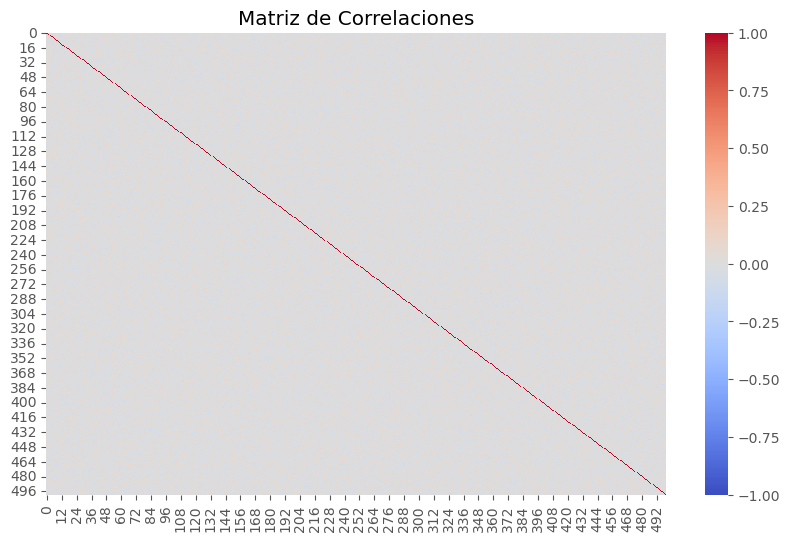

In [9]:
corr_mat = retornos_df.corr()

# Dibujar la matriz de correlaciones
plt.figure(figsize=(10, 6))
sns.heatmap(corr_mat, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de Correlaciones")
plt.show()

Definimos la función que calcula la volatilidad de la cartera equiponderada.

In [11]:
def volatilidad_cartera_equiponderada(retornos):
    """
    Calcula la volatilidad de una cartera equiponderada basada en los retornos de los activos.

    Parámetros:
    - retornos (numpy array): Una matriz donde cada columna representa los retornos de un activo y cada fila un período de tiempo.

    Retorna:
    - volatilidad (float): La volatilidad de la cartera equiponderada.
    """
    
    # Calcular la matriz de covarianza de los retornos
    matriz_cov = np.cov(retornos, rowvar=False)
    
    # Número de activos en la cartera
    n_days, n_act = retornos.shape    
    # Ponderaciones equiponderadas
    w = np.ones(n_act) / n_act
    
    # Calcular la varianza de la cartera
    varianza_cartera = w @ matriz_cov @ w.T
    
    # Calcular la volatilidad de la cartera
    volatilidad = np.sqrt(varianza_cartera)
    
    return volatilidad



Definimos la función que calcula la cartera de menor volatilidad y devuelve la volatilidad de la cartera y los pesos de cada activo. Por ahora **no entramos en los detalles de esta función**, lo veremos en el **TEMA 3**.

In [12]:
def calc_port_min_var(retornos):
    '''
    Calcula la cartera de mínima varianza
    retornos: matriz de retornos
    w: pesos de la cartera
    vol_min: volatilidad de la cartera
    '''
    n_days, n_act = retornos.shape
    w = cp.Variable(n_act)
    cov = np.cov(retornos.T)  
    objective = cp.Minimize(w.T @ cov @ w)
    const= [cp.sum(w) == 1, w >= 0]
    prob = cp.Problem(objective, const)
    port_min_var = prob.solve()
    vol_min = np.sqrt(port_min_var)
    return vol_min, w.value

Con los retornos generados, empezamos creando una cartera con dos activos y vamos aumentando el número de activos hasta llegar a `num_act`.

Para cada cartera calculamos la volatilidad, el VaR y el CVaR.

Hacemos gráficas para ver cómo varían al aumentar el número de activos en la cartera

In [13]:
vol_equi_lst = [] #lista de volatilidades mínimas

ret_cart_equi_lst = [] #lista de retornos de la cartera de mínima varianza
var_95_equi_lst = [] #lista de VaR al 95%
cvar_95_equi_lst = [] #lista de CVaR al 95%

# Calculamos la cartera de mínima varianza para cada número de activos
for i in tqdm(range(num_act-2)):

    tmp_data = retornos_df.iloc[:, :i+2] #seleccionamos los retornos de los i+2 primeros activos

    vol_equi = volatilidad_cartera_equiponderada(tmp_data) #calculamos la cartera de mínima varianza

    vol_equi_lst.append(vol_equi) #añadimos la volatilidad de la cartera de mínima varianza a la lista
    
    pesos = np.ones(i+2)/(i+2) #calculamos los pesos de la cartera equiponderada

    tmp_cart = tmp_data @ pesos.T #calculamos los retornos de la cartera de mínima varianza
    ret_cart_equi_lst.append(tmp_cart) #añadimos los retornos de la cartera de mínima varianza a la lista

    var_95_equi = np.percentile(tmp_cart, 5) #calculamos el VaR al 95%
    var_95_equi_lst.append(var_95_equi) #añadimos el VaR al 95% a la lista
    
    cvar_95_equi = np.mean(tmp_cart[tmp_cart <= var_95_equi]) #calculamos el CVaR al 95%
    cvar_95_equi_lst.append(cvar_95_equi) #añadimos el CVaR al 95% a la lista

100%|████████████████████████████████████████| 498/498 [00:01<00:00, 495.46it/s]


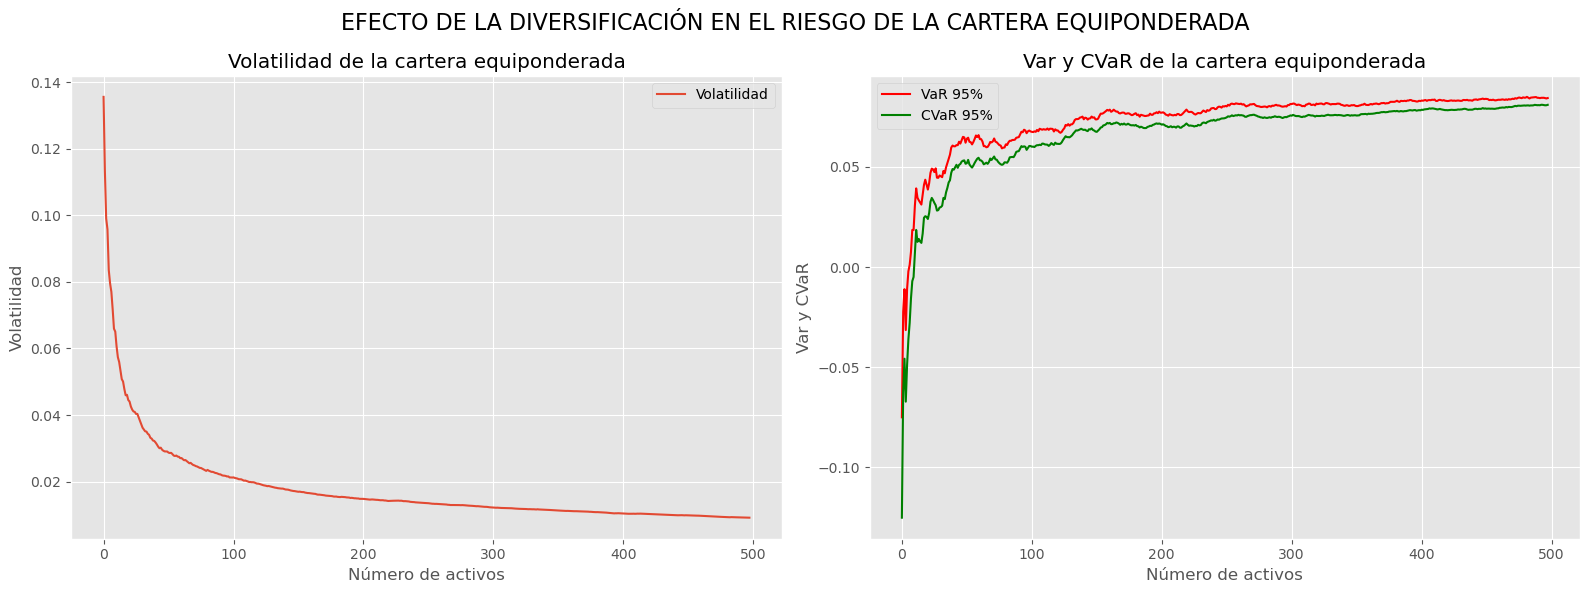

In [14]:
#hacemos la gráfica
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfica de la izquierda (Volatilidad)
ax1.plot(vol_equi_lst, label='Volatilidad')
ax1.set_xlabel('Número de activos')
ax1.set_ylabel('Volatilidad')
ax1.set_title('Volatilidad de la cartera equiponderada')
ax1.legend()

# Gráfica de la derecha (Otras métricas)
ax2.plot(var_95_equi_lst, label='VaR 95%', color='red')  
ax2.plot(cvar_95_equi_lst, label='CVaR 95%', color='green')
ax2.set_xlabel('Número de activos')
ax2.set_ylabel('Var y CVaR')
ax2.set_title('Var y CVaR de la cartera equiponderada')
ax2.legend()

fig.suptitle('EFECTO DE LA DIVERSIFICACIÓN EN EL RIESGO DE LA CARTERA EQUIPONDERADA', fontsize=16)

plt.tight_layout()  # Asegurar que no haya superposición de las subgráficas
plt.show()

En la figura se puede observar cómo a medida que aumenta el número de activos de la cartera, su volatilidad disminuye considerablemente.

Ahora hacemos lo mismo pero con la cartera de mínima volatilidad:

In [15]:
var_min_lst = [] #lista de volatilidades mínimas
pesos_lst = [] #lista de pesos de la cartera de mínima varianza
ret_cart_lst = [] #lista de retornos de la cartera de mínima varianza
var_95_lst = [] #lista de VaR al 95%
cvar_95_lst = [] #lista de CVaR al 95%

# Calculamos la cartera de mínima varianza para cada número de activos
for i in tqdm(range(num_act-2)):

    tmp_data = retornos_df.iloc[:, :i+2] #seleccionamos los retornos de los i+2 primeros activos

    var_min, pesos = calc_port_min_var(tmp_data) #calculamos la cartera de mínima varianza

    var_min_lst.append(var_min) #añadimos la volatilidad de la cartera de mínima varianza a la lista
    pesos_lst.append(pesos) #añadimos los pesos de la cartera de mínima varianza a la lista

    tmp_cart = tmp_data @ pesos.T #calculamos los retornos de la cartera de mínima varianza
    ret_cart_lst.append(tmp_cart) #añadimos los retornos de la cartera de mínima varianza a la lista

    var_95 = np.percentile(tmp_cart, 5) #calculamos el VaR al 95%
    var_95_lst.append(var_95) #añadimos el VaR al 95% a la lista
    
    cvar_95 = np.mean(tmp_cart[tmp_cart <= var_95]) #calculamos el CVaR al 95%
    cvar_95_lst.append(cvar_95) #añadimos el CVaR al 95% a la lista


100%|█████████████████████████████████████████| 498/498 [00:31<00:00, 15.60it/s]


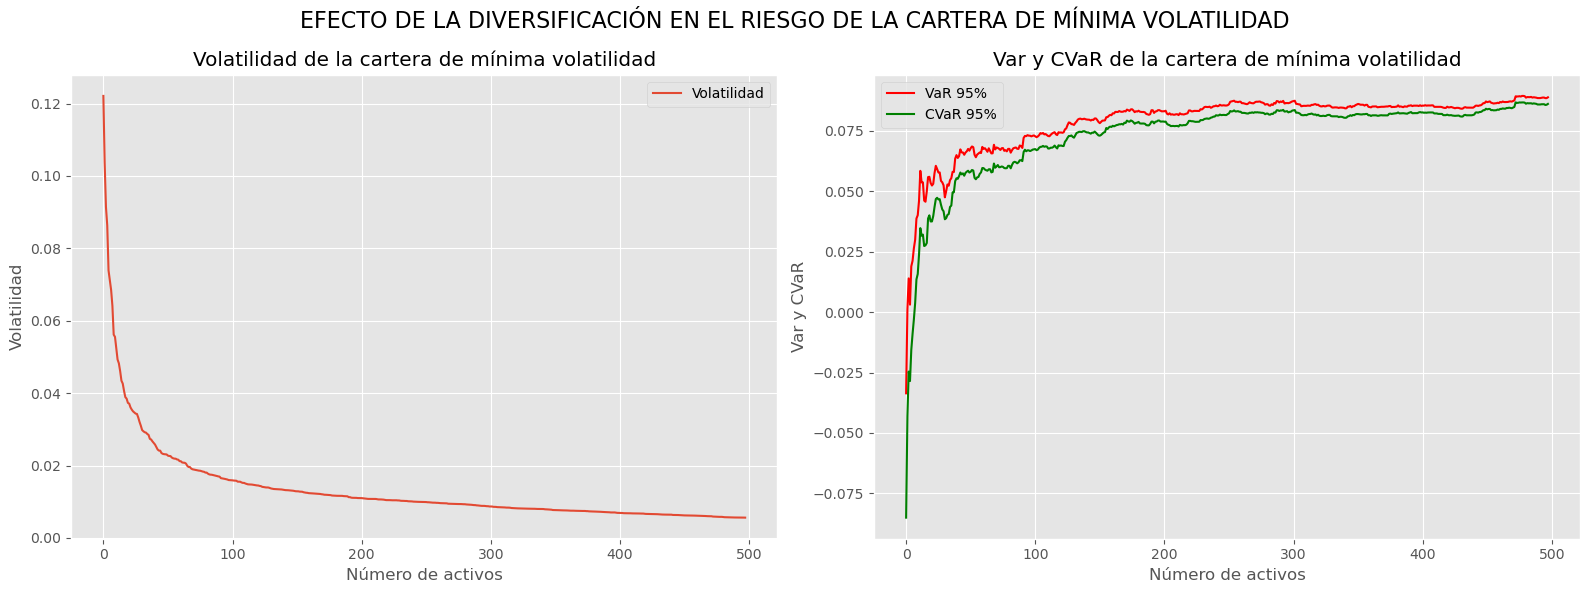

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfica de la izquierda (Volatilidad)
ax1.plot(var_min_lst, label='Volatilidad')
ax1.set_xlabel('Número de activos')
ax1.set_ylabel('Volatilidad')
ax1.set_title('Volatilidad de la cartera de mínima volatilidad')
ax1.legend()

# Gráfica de la derecha (Otras métricas)
ax2.plot(var_95_lst, label='VaR 95%', color='red')  
ax2.plot(cvar_95_lst, label='CVaR 95%', color='green')
ax2.set_xlabel('Número de activos')
ax2.set_ylabel('Var y CVaR')
ax2.set_title('Var y CVaR de la cartera de mínima volatilidad')
ax2.legend()

fig.suptitle('EFECTO DE LA DIVERSIFICACIÓN EN EL RIESGO DE LA CARTERA DE MÍNIMA VOLATILIDAD', fontsize=16)

plt.tight_layout()  # Asegurar que no haya superposición de las subgráficas
plt.show()

En la figura, podemos observar un comportamiento similar. Sin embargo, comparad la diferencia en los ejes verticales.

Veamos ahora qué efecto tiene, sobre el riesgo de las carteras, el orden en el que se incluyen los activos. Para ello, ordenamos los activos de mayor a menor volatilidad y volvemos a generar las carteras con los mismos números de activos que antes.

In [17]:
sorted_std = retornos_df.columns[np.argsort(desv)] 
retornos_sort_std_df = retornos_df[sorted_std]

In [18]:
var_min_std_lst = []
pesos_std_lst = []
ret_cart_std_lst = []
var_95_std_lst = []
cvar_95_std_lst = []

for i in tqdm(range(num_act-2)):
    tmp_data_std = retornos_sort_std_df.iloc[:, :i+2]
    var_min_std, pesos_std = calc_port_min_var(tmp_data_std)
    var_min_std_lst.append(var_min_std)
    pesos_std_lst.append(pesos_std)
    tmp_cart_std = tmp_data_std @ pesos_std.T
    ret_cart_lst.append(tmp_cart_std)
    var_95_std = np.percentile(tmp_cart_std, 5)
    var_95_std_lst.append(var_95_std)
    cvar_95_std_lst.append(np.mean(tmp_cart_std[tmp_cart_std <= var_95]))

100%|█████████████████████████████████████████| 498/498 [00:31<00:00, 15.66it/s]


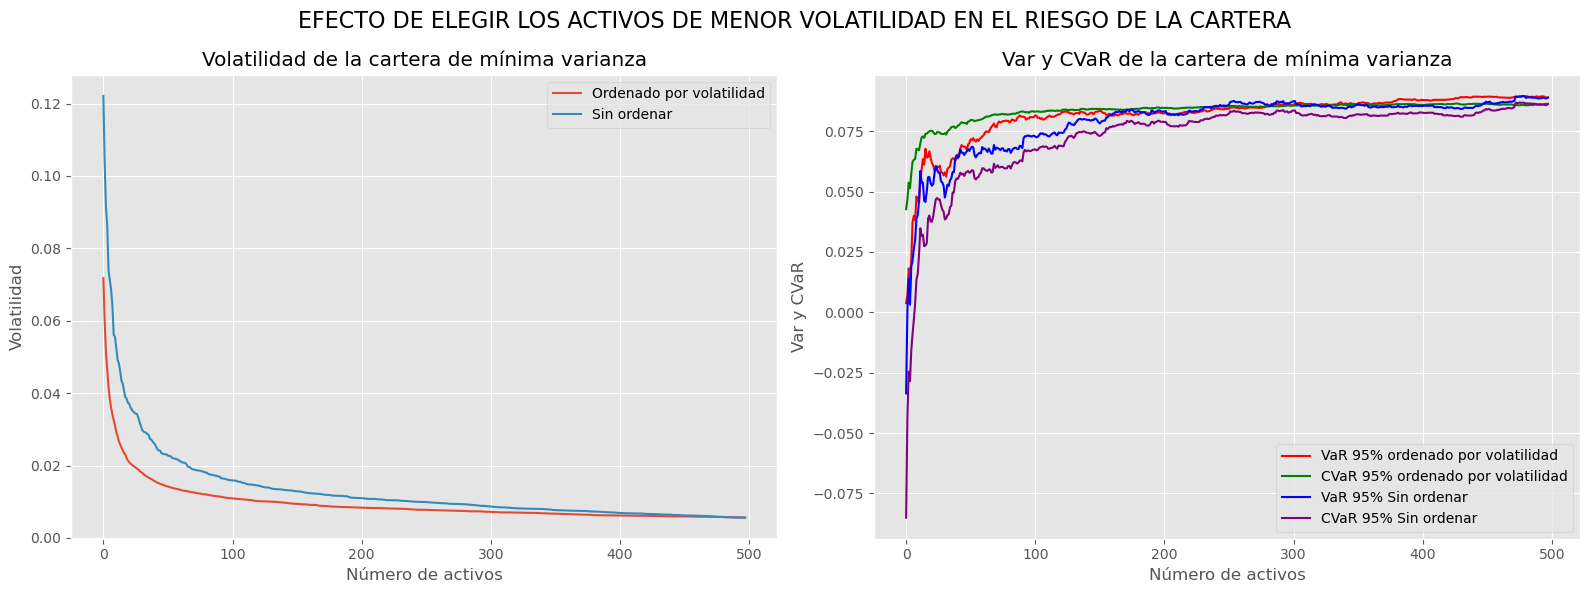

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfica de la izquierda (Volatilidad)
ax1.plot(var_min_std_lst, label='Ordenado por volatilidad')
ax1.plot(var_min_lst, label='Sin ordenar')
ax1.set_xlabel('Número de activos')
ax1.set_ylabel('Volatilidad')
ax1.set_title('Volatilidad de la cartera de mínima varianza')
ax1.legend()

# Gráfica de la derecha (Otras métricas)
ax2.plot(var_95_std_lst, label='VaR 95% ordenado por volatilidad', color='red')  
ax2.plot(cvar_95_std_lst, label='CVaR 95% ordenado por volatilidad', color='green')
ax2.plot(var_95_lst, label='VaR 95% Sin ordenar', color='blue')  
ax2.plot(cvar_95_lst, label='CVaR 95% Sin ordenar', color='purple')
ax2.set_xlabel('Número de activos')
ax2.set_ylabel('Var y CVaR')
ax2.set_title('Var y CVaR de la cartera de mínima varianza')
ax2.legend()

fig.suptitle('EFECTO DE ELEGIR LOS ACTIVOS DE MENOR VOLATILIDAD EN EL RIESGO DE LA CARTERA', fontsize=16)

plt.tight_layout()  # Asegurar que no haya superposición de las subgráficas
plt.show()

En la figura anterior se puede observar cómo la **velocidad de convergencia** es mucho mayor cuando seleccionamos los activos según su volatilidad.

---

### Análisis del efecto de la diversificación en el riesgo de una cartera usando los precios de cierre de S&P500

Veamos qué ocurre cuando los retornos no son independientes:

Llamando:

* Varianza media de los activos 

$$\bar{V} = \dfrac{1}{n}\sum_{i=1}^{n} \sigma _i^2 \quad \Rightarrow \quad \sum_{i=1}^{n} \sigma _i^2 = n \bar{V}$$

* Covarianza media entre activos 

$$\bar{\sigma_{ij}} = \dfrac{1}{n(n-1)}\sum_{i=1}^{n}\sum_{j=1}^{n}\sigma_{ij} \quad \Rightarrow \quad  \sum_{i=1}^{n}\sum_{j=1}^{n}\sigma_{ij} = n(n-1)\bar{\sigma_{ij}}$$

Sustituyendo en la ecuación de la varianza de una cartera equiponderada:

$$\sigma_p^2= \dfrac{1}{n^2}\sum_{i=1}^{n} \sigma _i^2 + \dfrac{1}{n^2}\sum_{i=1}^{n}\sum_{j=1}^{n}\sigma_{ij}$$

$$\sigma_p^2= \dfrac{1}{n^2}n \bar{V} + \dfrac{1}{n^2}n(n-1)\bar{\sigma_{ij}} = \dfrac{1}{n}\bar{V} + \dfrac{n-1}{n}\bar{\sigma_{ij}} $$

$$\sigma_p^2= \dfrac{\bar{V}}{n} + \bar{\sigma_{ij}} - \dfrac{\bar{\sigma_{ij}}}{n} $$

Si el número de activos $n$ tiende a infinito:

$$\lim_{n \to \infty} \sigma_p^2= \bar{\sigma_{ij}} $$

**Nos queda el riesgo sistémico o de mercado que no se puede eliminar con la diversificación**.

El riesgo sistémico es el riesgo que afecta a todos los activos de una cartera.

Vamos a cargar los datos completos del S&P500 para visualizar las pruebas:

In [21]:
sp_500_df = pd.read_excel('../data/SP500_comp_data.xlsx', index_col=0, parse_dates=True)

num_min = 2000 # Número mínimo de datos
sp_500_df = sp_500_df.dropna(axis=1, thresh=num_min)
sp_500_df.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,NaN,NaN,NaN,0.332589,NaN,NaN,3.885798,NaN,NaN,1.265625,...,NaN,20.2500,12.500,1.041667,NaN,NaN,NaN,NaN,3.5000,NaN
1990-01-03,NaN,NaN,NaN,0.334821,NaN,NaN,3.899826,NaN,NaN,1.328125,...,NaN,20.1875,12.375,1.041667,NaN,NaN,NaN,NaN,3.5625,NaN


In [22]:
# Calcular los retornos logarítmicos usando diff()
ret_sp500_df = np.log(sp_500_df).diff().dropna()

ret_sp500_df.head()  # Mostrar las primeras filas de los retornos logarítmicos

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-07,0.010866,0.023384,0.000673,-0.002463,0.004971,0.005539,0.009405,0.003026,0.013672,0.001117,...,0.069442,0.028432,0.004111,0.006730,0.003580,-0.008640,0.008968,0.004283,-0.021060,-0.010802
2015-07-08,-0.026485,-0.034012,-0.021885,-0.025136,-0.013214,-0.007392,-0.019305,-0.007364,-0.010800,-0.007473,...,-0.066942,-0.005325,-0.010920,-0.018179,-0.022517,-0.031300,-0.016812,-0.034878,-0.026208,-0.029676
2015-07-09,0.004377,0.009116,0.012917,-0.020607,0.004571,0.009507,-0.001219,-0.005522,0.001331,0.005983,...,0.010127,-0.011337,-0.004524,-0.007640,-0.000844,0.009937,-0.010243,-0.000277,0.021942,0.001934
2015-07-10,0.012258,0.038086,0.012509,0.026383,0.018368,0.005497,0.014932,0.011303,0.010482,0.001490,...,-0.012434,0.006579,0.007569,0.011536,-0.004230,0.032097,-0.000281,0.012008,0.020183,0.008340
2015-07-13,0.014113,0.028939,0.031194,0.019122,0.004899,0.005557,-0.004215,-0.006940,0.017760,0.010492,...,0.037683,-0.000298,0.002430,0.014858,0.018755,0.002748,0.007648,0.006901,0.008983,0.001702


Calculamos la cartera de mínima varianza:

In [23]:
var_sp500_min_lst = [] #lista de volatilidades mínimas
pesos_sp500_lst = [] #lista de pesos de la cartera de mínima varianza
ret_cart_sp500_lst = [] #lista de retornos de la cartera de mínima varianza
var_95_sp500_lst = [] #lista de VaR al 95%
cvar_95_sp500_lst = [] #lista de CVaR al 95%

num_act_sp500 = ret_sp500_df.shape[1] #número de activos

# Calculamos la cartera de mínima varianza para cada número de activos

for i in tqdm(range(num_act_sp500-2)):

    tmp_data = ret_sp500_df.iloc[:, :i+2] #seleccionamos los retornos de los i+2 primeros activos

    var_min_sp500, pesos_sp500 = calc_port_min_var(tmp_data) #calculamos la cartera de mínima varianza

    var_sp500_min_lst.append(var_min_sp500) #añadimos la volatilidad de la cartera de mínima varianza a la lista
    pesos_sp500_lst.append(pesos_sp500) #añadimos los pesos de la cartera de mínima varianza a la lista

    tmp_cart = tmp_data @ pesos_sp500.T #calculamos los retornos de la cartera de mínima varianza
    ret_cart_sp500_lst.append(tmp_cart) #añadimos los retornos de la cartera de mínima varianza a la lista

    var_95_sp500 = np.percentile(tmp_cart, 5) #calculamos el VaR al 95%
    var_95_sp500_lst.append(var_95_sp500) #añadimos el VaR al 95% a la lista
    
    cvar_95_sp500 = np.mean(tmp_cart[tmp_cart <= var_95_sp500]) #calculamos el CVaR al 95%
    cvar_95_sp500_lst.append(cvar_95_sp500) #añadimos el CVaR al 95% a la lista

100%|█████████████████████████████████████████| 481/481 [00:31<00:00, 15.41it/s]


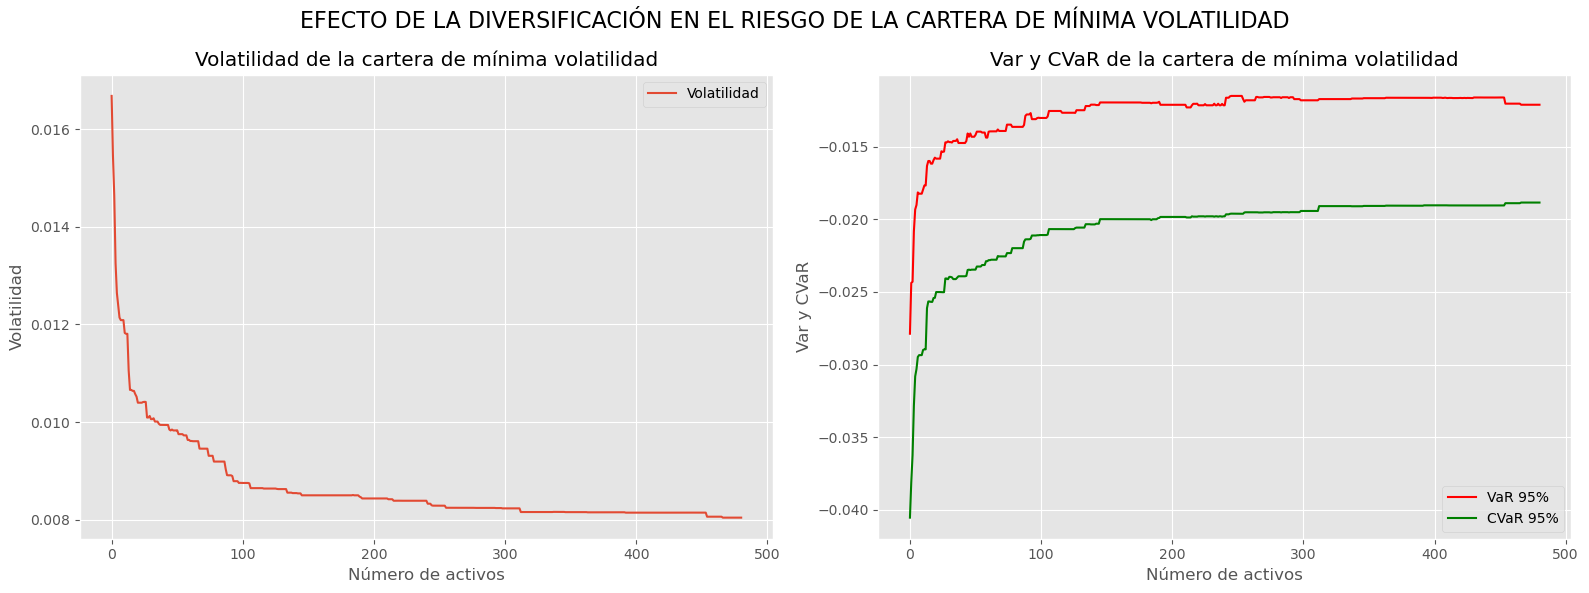

In [24]:
# HACER LA GRÁFICA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfica de la izquierda (Volatilidad)
ax1.plot(var_sp500_min_lst, label='Volatilidad')
ax1.set_xlabel('Número de activos')
ax1.set_ylabel('Volatilidad')
ax1.set_title('Volatilidad de la cartera de mínima volatilidad')
ax1.legend()

# Gráfica de la derecha (Otras métricas)
ax2.plot(var_95_sp500_lst, label='VaR 95%', color='red')  
ax2.plot(cvar_95_sp500_lst, label='CVaR 95%', color='green')
ax2.set_xlabel('Número de activos')
ax2.set_ylabel('Var y CVaR')
ax2.set_title('Var y CVaR de la cartera de mínima volatilidad')
ax2.legend()

fig.suptitle('EFECTO DE LA DIVERSIFICACIÓN EN EL RIESGO DE LA CARTERA DE MÍNIMA VOLATILIDAD', fontsize=16)

plt.tight_layout()  # Asegurar que no haya superposición de las subgráficas
plt.show()

Vamos a hacer el mismo experimento pero ordenando previamente según el mínimo de la suma de correlaciones entre activos, es decir, seleccionamos primero aquellos activos que están **menos correlados** con el resto.

In [25]:
corr_mat = ret_sp500_df.corr()
corr_sums = corr_mat.sum(axis=0)
sorted_columns = corr_sums.sort_values(ascending=True).index.tolist()
ret_sp500_sorted_df = ret_sp500_df[sorted_columns]

In [26]:
var_sp500_sorted_min_lst = [] #lista de volatilidades mínimas
pesos_sp500_sorted_lst = [] #lista de pesos de la cartera de mínima varianza
ret_cart_sp500_sorted_lst = [] #lista de retornos de la cartera de mínima varianza
var_95_sp500_sorted_lst = [] #lista de VaR al 95%
cvar_95_sp500_sorted_lst = [] #lista de CVaR al 95%

num_act_sp500_sorted = ret_sp500_sorted_df.shape[1] #número de activos

# Calculamos la cartera de mínima varianza para cada número de activos
for i in tqdm(range(num_act_sp500-2)):

    tmp_data_sp500_sorted = ret_sp500_sorted_df.iloc[:, :i+2] #seleccionamos los retornos de los i+2 primeros activos

    var_min_sp500_sorted, pesos_sp500_sorted = calc_port_min_var(tmp_data_sp500_sorted) #calculamos la cartera de mínima varianza

    var_sp500_sorted_min_lst.append(var_min_sp500_sorted) #añadimos la volatilidad de la cartera de mínima varianza a la lista
    pesos_sp500_sorted_lst.append(pesos_sp500_sorted) #añadimos los pesos de la cartera de mínima varianza a la lista

    tmp_cart_sp500_sorted = tmp_data_sp500_sorted @ pesos_sp500_sorted.T #calculamos los retornos de la cartera de mínima varianza
    ret_cart_sp500_sorted_lst.append(tmp_cart_sp500_sorted) #añadimos los retornos de la cartera de mínima varianza a la lista

    var_95_sp500_sorted = np.percentile(tmp_cart_sp500_sorted, 5) #calculamos el VaR al 95%
    var_95_sp500_sorted_lst.append(var_95_sp500_sorted) #añadimos el VaR al 95% a la lista
    
    cvar_95_sp500_sorted = np.mean(tmp_cart_sp500_sorted[tmp_cart_sp500_sorted <= var_95_sp500_sorted]) #calculamos el CVaR al 95%
    cvar_95_sp500_sorted_lst.append(cvar_95_sp500_sorted) #añadimos el CVaR al 95% a la lista

100%|█████████████████████████████████████████| 481/481 [00:31<00:00, 15.11it/s]


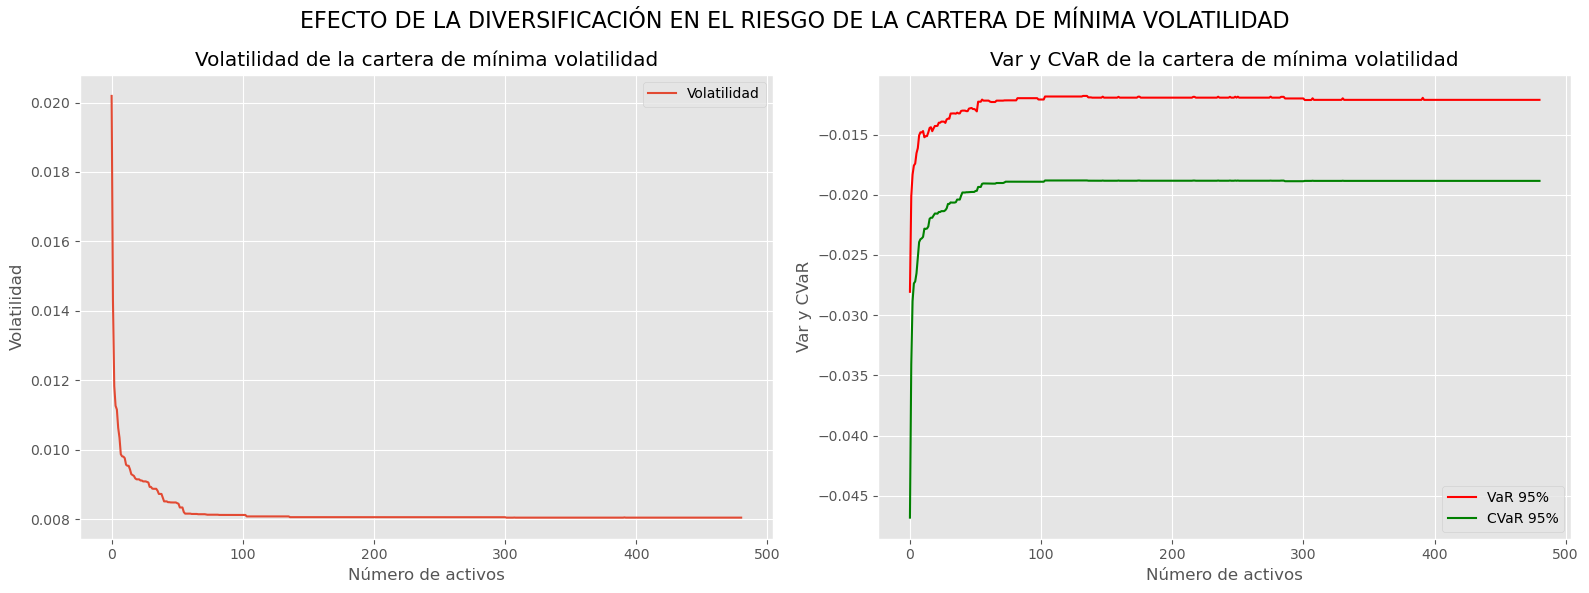

In [27]:
# HACER LA GRÁFICA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfica de la izquierda (Volatilidad)
ax1.plot(var_sp500_sorted_min_lst, label='Volatilidad')
ax1.set_xlabel('Número de activos')
ax1.set_ylabel('Volatilidad')
ax1.set_title('Volatilidad de la cartera de mínima volatilidad')
ax1.legend()

# Gráfica de la derecha (Otras métricas)
ax2.plot(var_95_sp500_sorted_lst, label='VaR 95%', color='red')  
ax2.plot(cvar_95_sp500_sorted_lst, label='CVaR 95%', color='green')
ax2.set_xlabel('Número de activos')
ax2.set_ylabel('Var y CVaR')
ax2.set_title('Var y CVaR de la cartera de mínima volatilidad')
ax2.legend()

fig.suptitle('EFECTO DE LA DIVERSIFICACIÓN EN EL RIESGO DE LA CARTERA DE MÍNIMA VOLATILIDAD', fontsize=16)

plt.tight_layout()  # Asegurar que no haya superposición de las subgráficas
plt.show()

Comparamos con la siguiente celda los dos resultados.

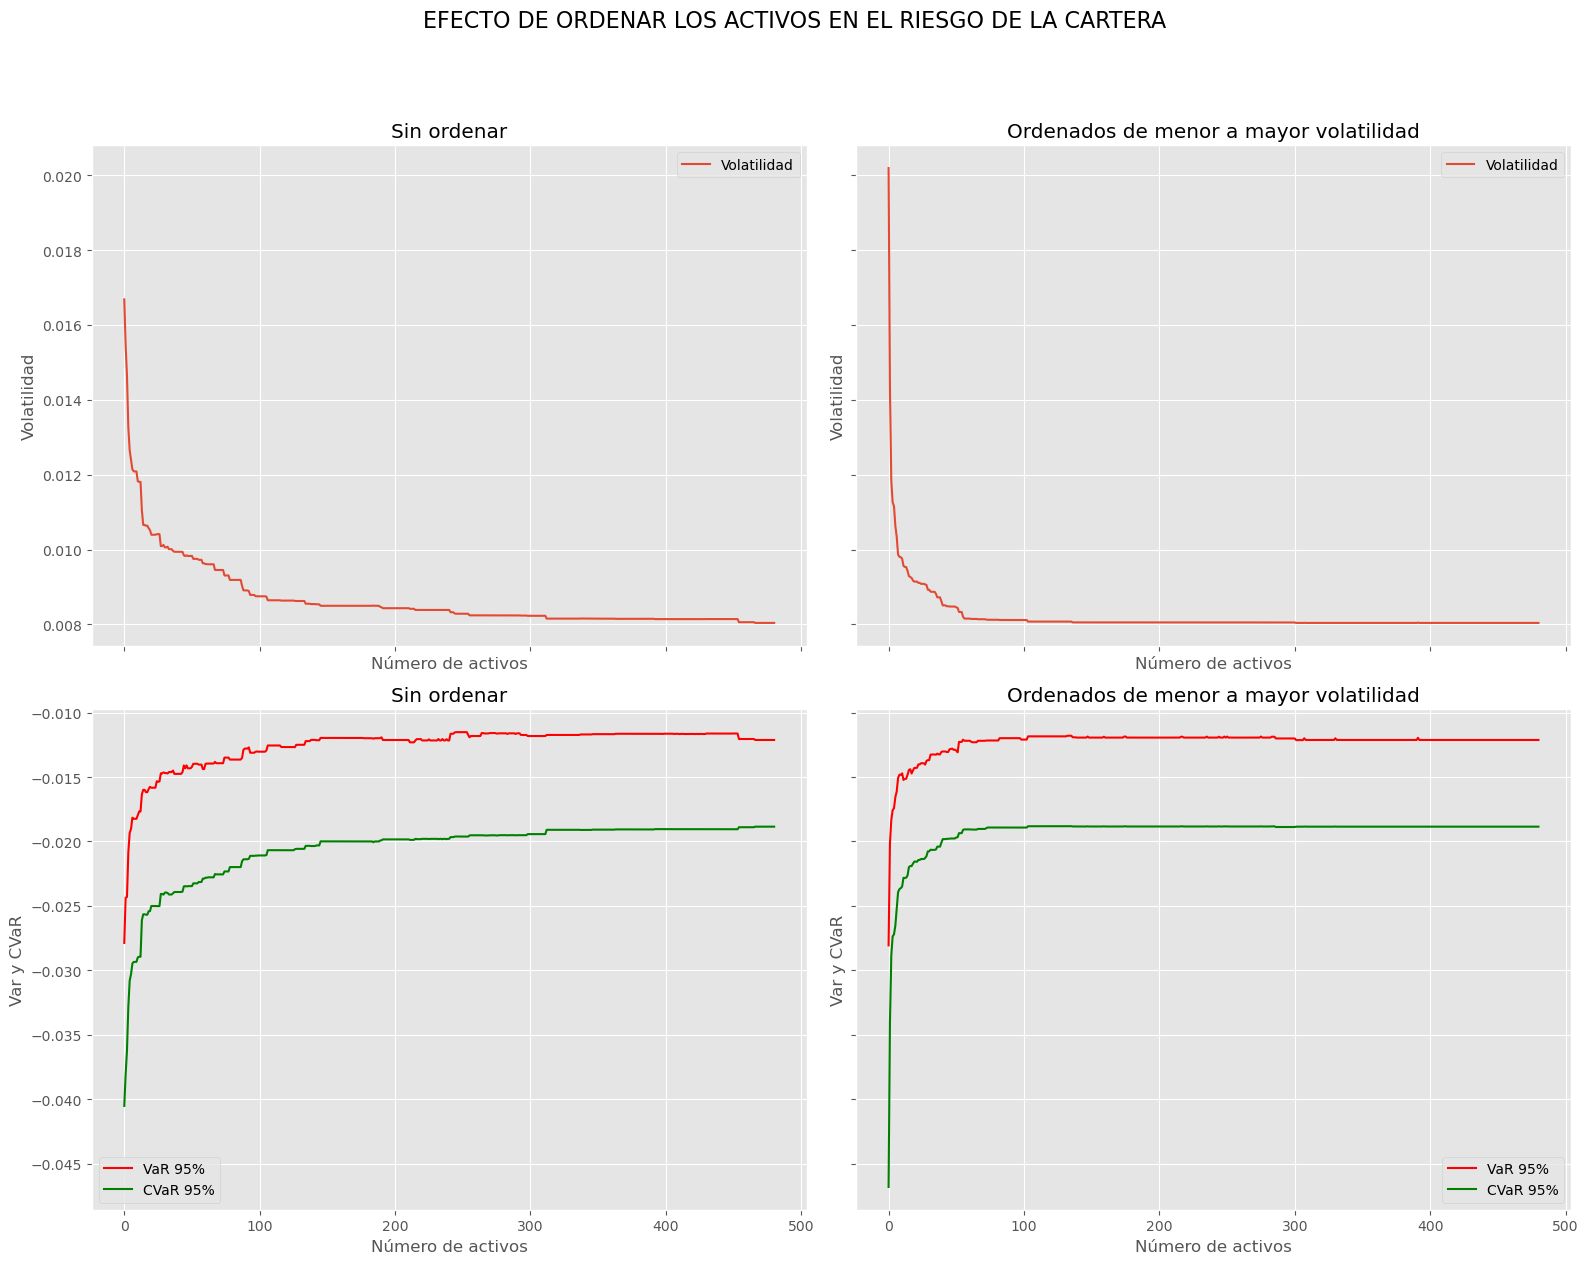

In [28]:

# Crear una figura con 2 filas y 2 columnas
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey='row')

# Primera gráfica (Volatilidad - Primera figura)
ax1.plot(var_sp500_min_lst, label='Volatilidad')
ax1.set_xlabel('Número de activos')
ax1.set_ylabel('Volatilidad')
ax1.set_title('Sin ordenar')
ax1.legend()

# Segunda gráfica (Otras métricas - Primera figura)
ax2.plot(var_sp500_sorted_min_lst, label='Volatilidad')
ax2.set_xlabel('Número de activos')
ax2.set_ylabel('Volatilidad')
ax2.set_title('Ordenados de menor a mayor volatilidad')
ax2.legend()


# Tercera gráfica (Volatilidad - Segunda figura)
ax3.plot(var_95_sp500_lst, label='VaR 95%', color='red')  
ax3.plot(cvar_95_sp500_lst, label='CVaR 95%', color='green')
ax3.set_xlabel('Número de activos')
ax3.set_ylabel('Var y CVaR')
ax3.set_title('Sin ordenar')
ax3.legend()

# Cuarta gráfica (Otras métricas - Segunda figura)
ax4.plot(var_95_sp500_sorted_lst, label='VaR 95%', color='red')  
ax4.plot(cvar_95_sp500_sorted_lst, label='CVaR 95%', color='green')
ax4.set_xlabel('Número de activos')
ax4.set_ylabel('Var y CVaR')
ax4.set_title('Ordenados de menor a mayor volatilidad')
ax4.legend()

# Título principal para toda la figura
fig.suptitle('EFECTO DE ORDENAR LOS ACTIVOS EN EL RIESGO DE LA CARTERA', fontsize=16, y=1.05)

# Ajustar el layout para que no haya superposición de las subgráficas
plt.tight_layout()
plt.show()


En las figuras se puede observar cómo ordenar por mínima suma de covarianzas, que puede interpretarse como **independencia con el resto de activos**, es una buena aproximación para mejorar la convergencia al mínimo riesgo de la cartera con **menos activos**.

**NOTA CHRIS: ¿POR QUE NO COMBINAR LAS DOS FIGURAS PARA COMPARAR MEJOR?**

**NOTA CHRIS: PROPONGO AÑADIR ESTA FIGURA PARA QUE SE VEA LO RAPIDO QUE LLEGA AL MINIMO**

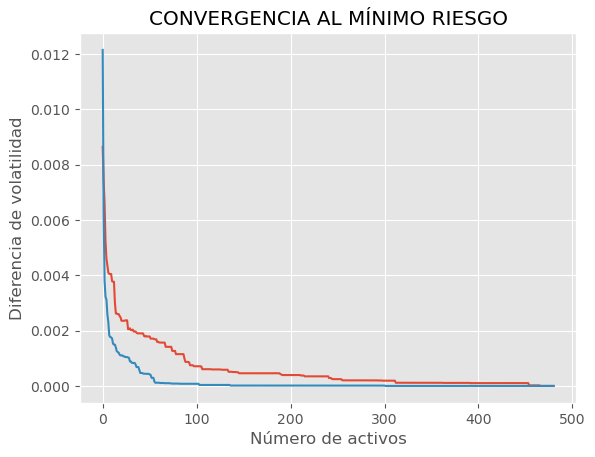

In [38]:
plt.title("CONVERGENCIA AL MÍNIMO RIESGO")
plt.plot(np.array(var_sp500_min_lst) - var_sp500_min_lst[-1])
plt.plot(np.array(var_sp500_sorted_min_lst) - var_sp500_sorted_min_lst[-1])
#plt.yscale("log")
plt.xlabel("Número de activos")
plt.ylabel("Diferencia de volatilidad")
plt.show()